# HW8: Ada Boost for Committee Training of Nonlinearly Separable Classifiers

Blanca Miller

STAT 760

04.12.2018

Initially each classifier is assigned a weight of 1. 

For the total number of classifiers wanted, M, iterate i=0...M:
1. Scouting: Build an evaluative matrix given the classifier set using data and corresponding labels where the rows represent a data input and the columns represent a classifier, then
        - classifier failures are recorded with a 0
        - classifier successes are recorded wiht a 1 

    
2. Drafting: Rank each classifier with each iteration through the classifier set to identify the best experts in the pool. Computer the error to get teh classifier wiht the next smallest error. 

3. Update the weights. 
     - Miss: w_i^(m+1) = w_i^(m) * e^α_m  
     - Hit: w_i^(m+1) = w_i^(m) * e^-α_m
     




__Objective:__ Create a data set containing a positive and negative class, where the positive class is a circle inside of the negative class, a square, and train a committee of classifiers using the adaptive boosting algorithm to make random cuts in the square. A series of "linear cuts" will combine to generate a classifier for the nonlinearly separable distribution of the positive class. 

A set of data, labels, and classifiers is given. The algorithm begins by setting the weights for all classifiers to 1. Then the algorithm iterates through the number of classifiers that is desired. An evaluative matrix is built given the classifier set using data and corresponding labels where the rows represent a data input and the columns represent a classifier, then
  - classifier failures are recorded with a 0
  - classifier successes are recorded wiht a 1 

From the set of classifier, one classifier is chosen based on having the minimal weighted sum error. Then the weight for the current classifier is computed. Lastly, the weight is updated for the next classifier iteration. The hope being that the iterative adjustments will eventually lead to weight values that accurately classify the majority of the training data. This is due to the algorithm's error criterion using the exponential loss function for β > 0, which results in e^-β < e^β. Specifically, the classifier with the worst performance sees substantial increases in weight value, e^β, while classifiers with the best performance see small increase in weight value, e^-β. The functions being,

- Error = w_n * e-α_m + w_e * e^α_m
- dError/dα_m = 1/2 * ln(1-e_m/e_m)

__Error criterion:__ exponential loss function for β > 0 and e^-β < e^β where 
- the cost of classifier failure is e^β and 
- the cost of classifier success is e^-β 
Thus, a miss is more heavily penalized than a hit.


__References:__
1. R. Rojas, 2009, AdaBoost & the Super Bowl of Classifiers A Tutorial Introduction to Adaptive Boosting
http://www.inf.fu-berlin.de/inst/ag-ki/rojas_home/documents/tutorials/adaboost4.pdf

__Ada Boost Algorithm:__ Ada boost is a three step algorithm that generates a robust and generalizable committee of classifiers from a given set of classifiers. The algorithm executes as follows,

Initialize all weights w_i = 1 

For the number of classifiers we want, M, we compute i = 0...M iterations:
1. Fit a classifier, k_m, to the training data that minimizes the weighted sum error: w_e = sum w_i^(m)
         
2. Set the weight α_m for the chosen weak classifier to α_m = 1/2 * ln((1-e_m)/e_m) where em = W_e/W , this is the derivative of the error function.
        - Error: w_n * e-α_m + w_e * e^α_m
        - dError/dα_m = 1/2 * ln(1-e_m/e_m)

3. Update the weight of the data points for the next iteration. If k_m(x_i) is 
       - Miss: w_i^(m+1) = w_i^(m) * e^α_m = w_i^(m) * sqrt((1-e_m)/e_m)
       - Hit: w_i^(m+1) = w_i^(m) * e^-α_m = w_i^(m) * sqrt(e_m/(1-e_m))
       

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles

### Construct Datasets: Circle & Square Positive & Negative Classes

In [2]:
X_train, y_train = make_gaussian_quantiles(cov=2., n_samples=300, n_features=2,
                               n_classes=2, random_state=1)
X_test, y_test = make_gaussian_quantiles(cov=2., n_samples=300, n_features=2,
                               n_classes=2, random_state=2)

### Print Data Set Contents for Verification

In [3]:
print('Training data: {}'.format(X_train.shape))
print('Training labels: {}'.format(y_train.shape))
print('Testing data: {}'.format(X_test.shape))
print('Testing labels: {}'.format(y_test.shape))

Training data: (300, 2)
Training labels: (300,)
Testing data: (300, 2)
Testing labels: (300,)


In [4]:
X_train[0:5,0:2]

array([[-2.67496068e-03, -1.97511955e+00],
       [ 2.69995268e-01,  2.97020930e+00],
       [-1.73793024e-01, -1.32337783e+00],
       [-8.50164101e-01,  7.86406700e-01],
       [-7.71841230e-01, -2.81199202e-01]])

In [5]:
y_train[0:5]

array([1, 1, 0, 0, 0])

In [6]:
X_test[0:5,0:2]

array([[-0.23187846,  0.5255531 ],
       [ 2.46329442, -0.63286181],
       [-0.79831427, -2.95260563],
       [ 1.00700665, -2.54659705],
       [-0.380504  ,  3.15562918]])

In [7]:
y_test[0:5]

array([0, 1, 1, 1, 1])

In [8]:
type(X_train)

numpy.ndarray

### Plot Training & Testing Data Sets

In [9]:
x_min_train, x_max_train = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min_train, y_max_train = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

In [10]:
x_min_test, x_max_test = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min_test, y_max_test = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1

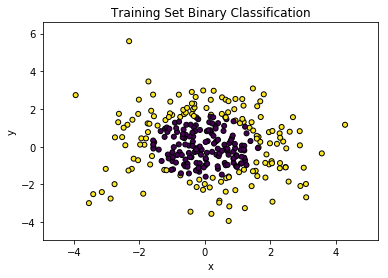

In [11]:
# plot training points
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c=y_train, s=25, edgecolor='k')
plt.xlim(x_min_train, x_max_train)
plt.ylim(y_min_train, y_max_train)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training Set Binary Classification')
plt.show()

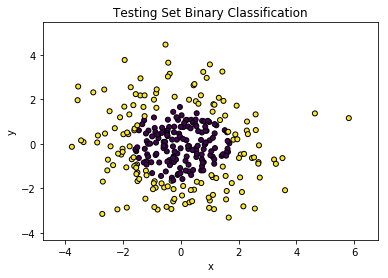

In [12]:
# plot testing points
plt.scatter(X_test[:, 0], X_test[:, 1], marker='o', c=y_test, s=25, edgecolor='k')
plt.xlim(x_min_test, x_max_test)
plt.ylim(y_min_test, y_max_test)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Testing Set Binary Classification')
plt.show()

### AdaBoost Functions

In [13]:
# Step 2 (a): Fit a classifier G_m(x) to the training data using the current weight observations
def get_classifier(X_train, y_train, X_test, y_test, clf):
    clf.fit(X_train, y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error(pred_train, X_train, y_train), get_error(pred_test, X_test, y_test)

In [14]:
# Step 2 (b): Compute the weighted error rate
def get_error(pred, data, y):
    for x in range(data.shape[0]):
        if pred[x] != y[x]:
            sum_pred = sum(data) / len(y)
    return sum_pred

def print_error(err):
    print 'Error rate: Training %.4f - Test %.4f' %err
    
def plot_error(err_train, err_test):
    df_error = pd.DataFrame([err_train, err_test]).T
    df_error.columns = ['Train', 'Test']
    
    plt = df_error.plot(linewidth=3, figsize=(8,6), color=['lightblue','darkblue'], grid=True)
    plt.set_xlabel('Num of Iterations', fontsize=12)
    plt.set_xticklabels(range(0,450,50))
    plt.set_ylabel('Error', fontsize=12)
    plt.set_title('Error vs # of iterations', fontsize=16)
    plt.axhline(y=err_test[0], linewidth=1, color='red', ls='dashed')

In [15]:
def adaboost(X_train, y_train, X_test, y_test, M, clf):
    n_train, n_test = len(X_train), len(X_test)
    
    # Step 1: initialize weights
    w = np.ones(n_train) / n_train
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    
    # Iterate through the desired number of classifiers
    for i in range(M):
        
        # Step 2 (a): Fit a classifier, the weak learner, with the current weight values
        clf.fit(X_train, y_train, sample_weight=w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        
        miss1 = [int(x) for x in (pred_train_i) != y_train]
        miss2 = [x if x==1 else  -1 for x in miss1]
        
        # Step 2 (b): Compute the weight error rate on the training sample
        err_m = np.dot(w,miss1) / sum(w)
        
        # Step 2 (c): Calculate the weight given the current classifier
        alpha_m = 0.5 * np.log((1-err_m) / float(err_m))
        
        # Step 3 (d): Set the individual weights for each observation to be used in the next iteration
        w = np.multiply(w, np.exp([float(x) * alpha_m for x in miss2]))
        
        # Add the prediction to the classifier set
        pred_train = [sum(x) for x in zip(pred_train, [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, [x * alpha_m for x in pred_test_i])]
    
    # Combine the predictions from all weak classifiers to produce the final predictions
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    
    return get_error(pred_train, X_train, y_train), \ 
            get_error(pred_test, X_test, y_test)

### Convert the Data Sets into Data Frames

In [16]:
#X_train = pd.DataFrame(X_train)
#y_train = pd.DataFrame(y_train)
#X_test = pd.DataFrame(X_test)
#y_test = pd.DataFrame(y_test)

In [17]:
#X_train.head()
#y_train.head()
#X_test.head()
#y_test.head()

In [21]:
### Fit a decision tree
clf_tree = DecisionTreeClassifier(max_depth=1, random_state=1)
err_tree = get_classifier(X_train, y_train, X_test, y_test, clf_tree)

In [26]:
err_tree

(array([0.0791008, 0.1060548]), array([-0.03251016, -0.08655909]))

In [22]:
# Fit Adaboost classifier using a decision tree as base estimator
# Test with different number of iterations
err_train, err_test = [err_tree[0]], [err_tree[1]]
x_range = range(10, 410, 10)
for i in x_range:    
    err_i = adaboost(X_train, y_train, X_test, y_test, i, clf_tree)
    err_train.append(err_i[0])
    err_test.append(err_i[1])

In [31]:
err_train = pd.DataFrame(err_train)
err_test = pd.DataFrame(err_test)

          0         1
0  -0.03251 -0.086559
1  -0.03251 -0.086559
2  -0.03251 -0.086559
3  -0.03251 -0.086559
4  -0.03251 -0.086559
5  -0.03251 -0.086559
6  -0.03251 -0.086559
7  -0.03251 -0.086559
8  -0.03251 -0.086559
9  -0.03251 -0.086559
10 -0.03251 -0.086559
11 -0.03251 -0.086559
12 -0.03251 -0.086559
13 -0.03251 -0.086559
14 -0.03251 -0.086559
15 -0.03251 -0.086559
16 -0.03251 -0.086559
17 -0.03251 -0.086559
18 -0.03251 -0.086559
19 -0.03251 -0.086559
20 -0.03251 -0.086559
21 -0.03251 -0.086559
22 -0.03251 -0.086559
23 -0.03251 -0.086559
24 -0.03251 -0.086559
25 -0.03251 -0.086559
26 -0.03251 -0.086559
27 -0.03251 -0.086559
28 -0.03251 -0.086559
29 -0.03251 -0.086559
30 -0.03251 -0.086559
31 -0.03251 -0.086559
32 -0.03251 -0.086559
33 -0.03251 -0.086559
34 -0.03251 -0.086559
35 -0.03251 -0.086559
36 -0.03251 -0.086559
37 -0.03251 -0.086559
38 -0.03251 -0.086559
39 -0.03251 -0.086559
40 -0.03251 -0.086559


In [29]:
plot_error(err_train, err_test)

TypeError: Empty 'DataFrame': no numeric data to plot

In [ ]:
def error(h, data):
    return sum(1 for x,y in data if h(x) != y) / len(data)

In [24]:
# data is a list of (example, label) pairs
def error(hypothesis, data):
    return sum(1 for x,y in data if hypothesis(x) != y) / len(data)

In [44]:
X1, y1 = make_gaussian_quantiles(cov=6, n_samples=1000, n_features=2,
                               n_classes=2, random_state=1)
x_min_train, x_max_train = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min_train, y_max_train = X1[:, 1].min() - 1, X1[:, 1].max() + 1

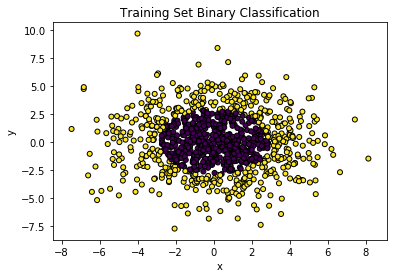

In [45]:
# plot training points
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=y1, s=25, edgecolor='k')
plt.xlim(x_min_train, x_max_train)
plt.ylim(y_min_train, y_max_train)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training Set Binary Classification')
plt.show()

In [50]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_test)

array([[71, 79],
       [79, 71]])